In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd 

plt.style.use('seaborn-v0_8-darkgrid')

from utils import *

### Define parameters

In [3]:
# Seed params
base_seed = 55
num_seeds=10

# Random walk
num_steps_in_walk = 720   # number of minutes 
step_size = 1
lower_bound = 0
upper_bound = 100
starting_value = 50

# Poisson arrival process
all_veh_arrival_rate = 10/60               # 10 veh/hr
connected_av_adoption_frac = 0.10          # 10% adoption rate
connected_veh_rate = all_veh_arrival_rate * connected_av_adoption_frac

# For plot outputs
plots_dir_name = 'figs'
fontsize = 20


In [4]:
# Functions for simulating random walks and Poisson processes
def bounded_random_walker(n_steps, step_size=1, lower_bound=0, upper_bound=100, starting_value=0, seed=None):
  """Generates a random walk bounded between lower_bound and upper_bound.

  Args:
    n_steps: The number of steps in the random walk.
    step_size: The size of each step in the random walk.
    lower_bound: The lower bound for the random walk.
    upper_bound: The upper bound for the random walk.
    starting_value: The starting value for the random walk.
    seed: An optional random seed.

  Returns:
    A numpy array representing the random walk.
  """

  if seed is not None:
    np.random.seed(seed)

  random_walk = np.zeros(n_steps)
  random_walk[0] = starting_value
  for i in range(1, n_steps):
    random_step = np.random.choice([-step_size, step_size])
    random_walk[i] = np.clip(random_walk[i-1] + random_step, lower_bound, upper_bound)
  return random_walk


def simulate_rounded_poisson_process(rate, time_interval, seed=None):
  """Simulates a Poisson arrival process with arrival times rounded to the nearest integer.

  Args:
    rate: The arrival rate of the Poisson process.
    time_interval: The total time interval to simulate.
    seed: An optional random seed.

  Returns:
    A list of arrival times.
  """

  if seed is not None:
    np.random.seed(seed)

  # Calculate the expected number of arrivals
  expected_arrivals = rate * time_interval

  # Generate the interarrival times -- do this for 2x the number of expected arrivals, to be safe 
  # (Don't want arrivals to end prior to the end of the time interval)
  interarrival_times = np.random.exponential(scale=1/rate, size=int(expected_arrivals*2))

  # Calculate the arrival times
  arrival_times = np.cumsum(interarrival_times)

  # Round the arrival times to the nearest integer
  rounded_arrival_times = np.round(arrival_times).astype(int)

  # Keep only the arrival times within the specified interval
  rounded_arrival_times = rounded_arrival_times[rounded_arrival_times <= (time_interval - 1)]

  return rounded_arrival_times


def get_observed_probabilities(true_probabilities, rounded_arrival_times):
    """
    Given a list of true probabilities and a series of arrival times, returns the observed trajectory of probabilities,
    where a probability is assumed to be unchanged until a new one is observed. 

    Parameters
    ----------
    true_probabilities - array of true probabilities
    rounded_arrival_times - array of arrival times (the points at which the true probabilities are observed)

    Returns
    ----------
    observed_probabilities - array of observed probabilities where unobserved
                                ones are assumed to be the same as the last observed one

    """

    observed_probabilities = np.zeros(len(true_probabilities))

    # We allow the connected AVs to have a 'freebie' by knowing the initial probability
    observed_probabilities[0] = true_probabilities[0]
    next_arrival_time_idx = 0
    next_arrival_time = rounded_arrival_times[next_arrival_time_idx]

    for i in range(1, len(true_probabilities)):

        # Handle the edge case where the first arrival(s) occurs at time 0
        if i > next_arrival_time:
            old_arrival_time = next_arrival_time
            while next_arrival_time == old_arrival_time:
                next_arrival_time_idx += 1
                next_arrival_time = rounded_arrival_times[next_arrival_time_idx]

        # If the next arrival time is greater than the current time, the probability is unchanged
        if i < next_arrival_time:
            observed_probabilities[i] = observed_probabilities[i-1]

        # If the next arrival time is equal to the current time, the probability is set to the true probability
        elif i == next_arrival_time:
            observed_probabilities[i] = true_probabilities[i]

            # Set the next arrival time, being sure to handle the case where multiple arrivals occur at once 
            old_arrival_time = next_arrival_time
            while next_arrival_time == old_arrival_time:
                next_arrival_time_idx += 1
                
                # Handle case where last arrival has already occurred
                if next_arrival_time_idx == len(rounded_arrival_times):
                    next_arrival_time = np.inf
                # Otherwise set the next arrival time
                else:
                    next_arrival_time = rounded_arrival_times[next_arrival_time_idx]
                
        
    return observed_probabilities


def calc_mean_abs_error(true_probabilities, observed_probabilities, verbose=False):
    """
    Calculates the mean absolute error between the true and observed probabilities
    """

    mean_abs_error = np.mean(np.abs(true_probabilities - observed_probabilities))

    if verbose:
        print(f"Mean Absolute Error: {mean_abs_error:.2f} percentage points")

    return np.round(mean_abs_error, 2)


def run_sims_to_get_error(base_seed, num_seeds, plot_walks=False, verbose=False, second_plot=False):
    """
    Function to run the simulations and calculate error metrics

    Returns:
        - mean_error: the mean of the mean absolute errorsa across all walks (seeds)
        - var_error: the variance of the mean absolute errors across all seeds
        - mean_error_per_walk_list: list comprised of the mean absolute error for each random walk (length = num_seeds)
        - stepwise_errors_across_all_walks: list of the stepwise absolute errors across all random walks (length = num_seeds * num_steps_in_walk)
    """
    
    stepwise_errors_across_all_walks = []
    mean_error_per_walk_list = []
    
    for i in range(num_seeds):
        if verbose: 
          print(f"Seed {i+1}/{num_seeds}")
        seed = base_seed + i

        # Generate a bounded random walk
        true_probabilities = bounded_random_walker(
          num_steps_in_walk,
          step_size=step_size, 
          lower_bound=lower_bound, 
          upper_bound=upper_bound,
          starting_value=starting_value,
          seed=seed,
          )

        # Simulate a Poisson arrival process for 'connected' vehicles which can observe the true parking probability
        rounded_arrival_times = simulate_rounded_poisson_process(
            rate=connected_veh_rate,
            time_interval=num_steps_in_walk,
            seed=seed,
            )

        # Get observed probabilities
        observed_probabilities = get_observed_probabilities(
          true_probabilities=true_probabilities,
          rounded_arrival_times=rounded_arrival_times,
          )

        if plot_walks:
            _, ax = plt.subplots() 

            # Plot the random walk
            ax.scatter(rounded_arrival_times, true_probabilities[rounded_arrival_times], color='darksalmon', label='Connected user arrivals', s=100)
            ax.plot(observed_probabilities, label='Observed parking probability', color='salmon')
            ax.plot(true_probabilities, label='True parking probability', color='purple')

            ax.set_xlabel("Time (hours)", fontsize=fontsize)
            ax.set_ylim(0, 100)
            ax.set_yticks(np.arange(0, 101, 10))
            ax.yaxis.grid(True, linestyle='-', color='white', alpha=0.7) # Horizontal grid lines
            ax.yaxis.set_tick_params(labelsize=fontsize)
            ax.set_ylabel("Parking probability (%)", fontsize=fontsize)

            # Replace minutes with hours
            ax.set_xticks(np.arange(0, num_steps_in_walk + 1, 60))
            ax.set_xticklabels(np.arange(0, num_steps_in_walk / 60 + 1, 1).astype(int), fontsize=fontsize)

            # For side-by-side inclusion in paper, incude legend only on second plot
            if second_plot:
               ax.legend(fontsize=fontsize)

            plt.tight_layout()
            plt.savefig(f"{plots_dir_name}/random_walk_lambda-{np.round(all_veh_arrival_rate*60).astype(int)}_adoption-{np.round(connected_av_adoption_frac*100).astype(int)}_seed-{seed}.pdf")
            plt.show()
            plt.close()

        stepwise_absolute_error_this_walk = np.abs(true_probabilities - observed_probabilities)
        mean_error_this_walk = calc_mean_abs_error(true_probabilities=true_probabilities, observed_probabilities=observed_probabilities)

        stepwise_errors_across_all_walks.extend(stepwise_absolute_error_this_walk)
        mean_error_per_walk_list.append(mean_error_this_walk)

    # Get mean error and variance of the mean error
    mean_error = np.mean(mean_error_per_walk_list)
    var_error = np.var(mean_error_per_walk_list)

    print(f"Mean error across {num_seeds} seeds: {mean_error:.2f} percentage points")

    return mean_error, var_error, mean_error_per_walk_list, stepwise_errors_across_all_walks


### Plot difference between observed probabilities and true probabilities

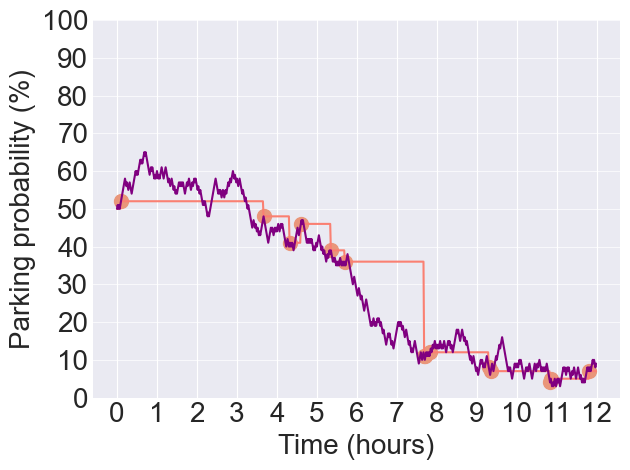

Mean error across 1 seeds: 5.46 percentage points


In [5]:
all_veh_arrival_rate = 10/60               # 10 veh/hr
connected_av_adoption_frac = 0.10          # 10% adoption rate


connected_veh_rate = all_veh_arrival_rate * connected_av_adoption_frac
_ = run_sims_to_get_error(base_seed, num_seeds=1, plot_walks=True)

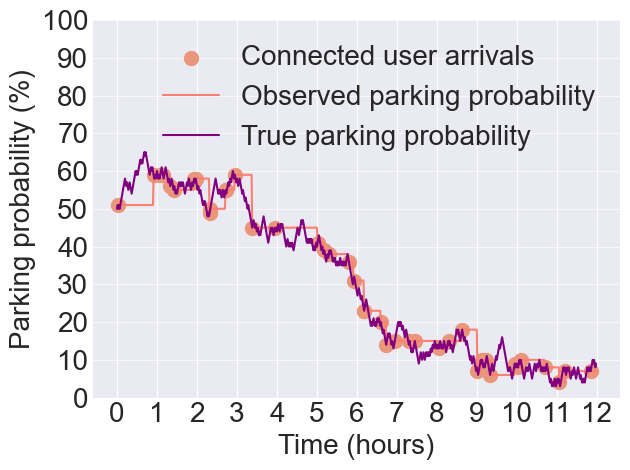

Mean error across 1 seeds: 2.83 percentage points


In [6]:
all_veh_arrival_rate = 20/60               # 20 veh/hr
connected_av_adoption_frac = 0.20          # 20% adoption rate


connected_veh_rate = all_veh_arrival_rate * connected_av_adoption_frac
_ = run_sims_to_get_error(base_seed, num_seeds=1, plot_walks=True, second_plot=True)

### Plot error as a function of overall arrival rates and connected user adoption rate

In [ ]:
# Redefine variables of interest
connected_av_adoption_frac = 0.20          # 20% adoption rate
all_veh_arrival_rates = [10/60, 20/60, 30/60, 40/60, 50/60, 60/60]       # 10, 20, 30, 40, 50, 60 veh/hr
num_seeds = 100
fontsize = 14

In [8]:
error_means = []
error_vars = []
mean_error_per_walk_list_across_all_arrival_rates = []
stepwise_errors_across_all_arrival_rates = []

base_seed_to_use = base_seed

for all_veh_arrival_rate in all_veh_arrival_rates:

    connected_veh_rate = all_veh_arrival_rate * connected_av_adoption_frac
    
    error_mean, error_var, mean_error_per_walk_list, stepwise_errors_across_all_walks = run_sims_to_get_error(base_seed_to_use, num_seeds, plot_walks=False)
    base_seed_to_use += num_seeds

    error_means.append(error_mean)
    error_vars.append(error_var)
    mean_error_per_walk_list_across_all_arrival_rates.append(mean_error_per_walk_list)
    stepwise_errors_across_all_arrival_rates.append(stepwise_errors_across_all_walks)


Mean error across 100 seeds: 3.62 percentage points
Mean error across 100 seeds: 2.67 percentage points
Mean error across 100 seeds: 2.08 percentage points
Mean error across 100 seeds: 1.80 percentage points
Mean error across 100 seeds: 1.57 percentage points
Mean error across 100 seeds: 1.43 percentage points


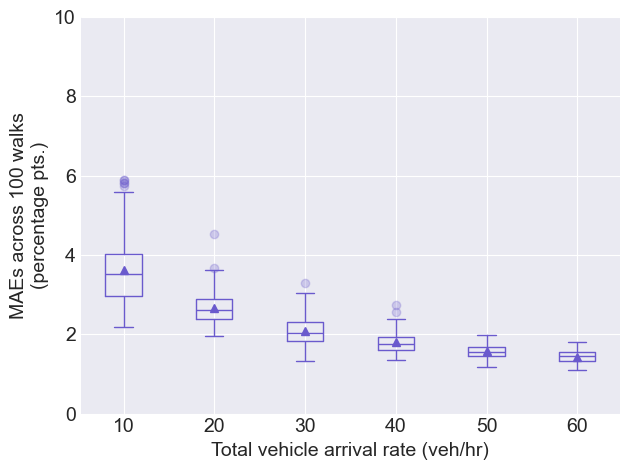

In [10]:
# Create a box-and-whisker plot

box_and_whisker_color = 'slateblue'
mean_median_color = 'slateblue'

arrival_rates_multiplied = np.array(all_veh_arrival_rates) * 60

plt.boxplot(mean_error_per_walk_list_across_all_arrival_rates,
            positions=arrival_rates_multiplied,
            widths=4,                       # widths adjust the width of the boxplot
            showfliers=True,                # showfliers shows outlier points
            showmeans=True,
            boxprops={'color': box_and_whisker_color},
            whiskerprops={'color': box_and_whisker_color},
            capprops={'color': box_and_whisker_color},
            flierprops={'markerfacecolor': box_and_whisker_color, 'markeredgecolor': box_and_whisker_color, 'alpha': 0.25},
            medianprops={'color': mean_median_color},
            meanprops={'markerfacecolor': mean_median_color, 'markeredgecolor': mean_median_color}
            ) 

plt.xlabel("Total vehicle arrival rate (veh/hr)", fontsize=fontsize)
plt.ylabel(f"MAEs across {num_seeds} walks\n(percentage pts.)", fontsize=fontsize)
plt.xticks(arrival_rates_multiplied, [int(x) for x in arrival_rates_multiplied], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0, 10.0)  
plt.tight_layout()
plt.savefig(f"{plots_dir_name}/error_boxplot_arrival.pdf")
plt.show()

In [11]:
# Redefine variables of interest
all_veh_arrival_rate = 20/60               # 20 veh/hr
connected_av_adoption_fracs = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60]       # 5, 10, 20, 30, 40, 50, 60% adoption rates

In [12]:
error_means = []
error_vars = []
mean_error_per_walk_list_across_all_adoption_rates = []
stepwise_errors_across_all_adoption_rates = []

base_seed_to_use = base_seed

for connected_av_adoption_frac in connected_av_adoption_fracs:

    connected_veh_rate = all_veh_arrival_rate * connected_av_adoption_frac
    
    error_mean, error_var, mean_error_per_walk_list, stepwise_errors_across_all_walks = run_sims_to_get_error(base_seed_to_use, num_seeds, plot_walks=False)
    base_seed_to_use += num_seeds

    error_means.append(error_mean)
    error_vars.append(error_var)
    mean_error_per_walk_list_across_all_adoption_rates.append(mean_error_per_walk_list)
    stepwise_errors_across_all_adoption_rates.append(stepwise_errors_across_all_walks)

Mean error across 100 seeds: 4.82 percentage points
Mean error across 100 seeds: 3.77 percentage points
Mean error across 100 seeds: 2.58 percentage points
Mean error across 100 seeds: 2.10 percentage points
Mean error across 100 seeds: 1.80 percentage points
Mean error across 100 seeds: 1.61 percentage points
Mean error across 100 seeds: 1.42 percentage points


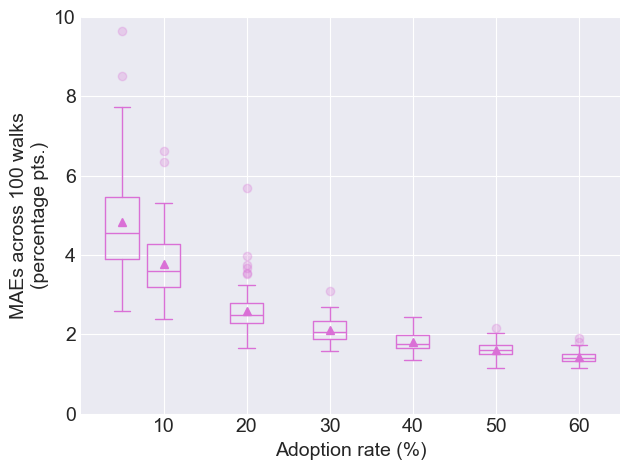

In [13]:
# Create a box-and-whisker plot

box_and_whisker_color = 'orchid'
mean_median_color = 'orchid'

connected_av_adoption_fracs_multiplied = np.array(connected_av_adoption_fracs) * 100

plt.boxplot(mean_error_per_walk_list_across_all_adoption_rates,
            positions=connected_av_adoption_fracs_multiplied,
            widths=4,                       # widths adjust the width of the boxplot
            showfliers=True,                # showfliers shows outlier points
            showmeans=True,
            boxprops={'color': box_and_whisker_color},
            whiskerprops={'color': box_and_whisker_color},
            capprops={'color': box_and_whisker_color},
            flierprops={'markerfacecolor': box_and_whisker_color, 'markeredgecolor': box_and_whisker_color, 'alpha': 0.25},
            medianprops={'color': mean_median_color},
            meanprops={'markerfacecolor': mean_median_color, 'markeredgecolor': mean_median_color}
            ) 

plt.xlabel("Adoption rate (%)", fontsize=fontsize)
plt.ylabel(f"MAEs across {num_seeds} walks\n(percentage pts.)", fontsize=fontsize)
plt.xticks(connected_av_adoption_fracs_multiplied[1:], [int(x) for x in connected_av_adoption_fracs_multiplied[1:]], fontsize=fontsize)
plt.ylim(0, 10.0)  
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"{plots_dir_name}/error_boxplot_adoption.pdf")
plt.show()

## Using Real-World Data from Seattle Dept. of Transportation

### Define parameters

In [14]:
# Define variables of interest
target_date_str = '01/30/2025'

occupancy_df_path = 'seattle_data/Paid_Parking_Occupancy__Last_30_Days__20250203.csv'
transactions_df_path = 'seattle_data/Paid_Parking_Transaction_Data_20250203.csv'

pct_connected_users = 30
random_seed = 1

plot=False

### Compare observed and true rates at two different locations

In [15]:
parking_key_list = [1017, 1018, 12869, 12874, 13301, 13302, 25705, 25706, 35909, 46250, 46254, 58629, 58629, 68914, 70741, 70746, 79354, 80198, 80878] # SDOT paid parking near Pike Place Market

local_occupancy_df = get_daily_occupancy_df(occupancy_df_path, target_date_str, parking_key_list, plot=plot)
local_transactions_df = get_daily_transactions_df(transactions_df_path, target_date_str, parking_key_list, plot=plot)
observed_occupancy_df_pikeplace, connected_user_transactions_df_pikeplace = get_daily_connected_transactions_and_observed_occupancy(pct_connected_users, local_occupancy_df, local_transactions_df, random_seed)

Original size: 4.21 GB
Size when filtered to only 2025-01-30 date: 0.47 GB
Number of parking spaces in [1017, 1018, 12869, 12874, 13301, 13302, 25705, 25706, 35909, 46250, 46254, 58629, 58629, 68914, 70741, 70746, 79354, 80198, 80878] parking areas:
	61
Original size: 0.06 GB
Size when filtered to only 2025-01-30 date: 0.01 GB
Dropped 1 row(s) from local_transactions_df prior to 8am
143 connected user transactions from 30% of users, compared to 478 transactions from all users


In [16]:
parking_key_list = [94731, 94732]   # SDOT paid parking near Carl S. English Jr. Botanical Garden

local_occupancy_df = get_daily_occupancy_df(occupancy_df_path, target_date_str, parking_key_list, plot=plot)
local_transactions_df = get_daily_transactions_df(transactions_df_path, target_date_str, parking_key_list, plot=plot)
observed_occupancy_df_botanical, connected_user_transactions_df_botanical = get_daily_connected_transactions_and_observed_occupancy(pct_connected_users, local_occupancy_df, local_transactions_df, random_seed)

Original size: 4.21 GB
Size when filtered to only 2025-01-30 date: 0.47 GB
Number of parking spaces in [94731, 94732] parking areas:
	72
Original size: 0.06 GB
Size when filtered to only 2025-01-30 date: 0.01 GB
Dropped 0 row(s) from local_transactions_df prior to 8am
8 connected user transactions from 30% of users, compared to 27 transactions from all users


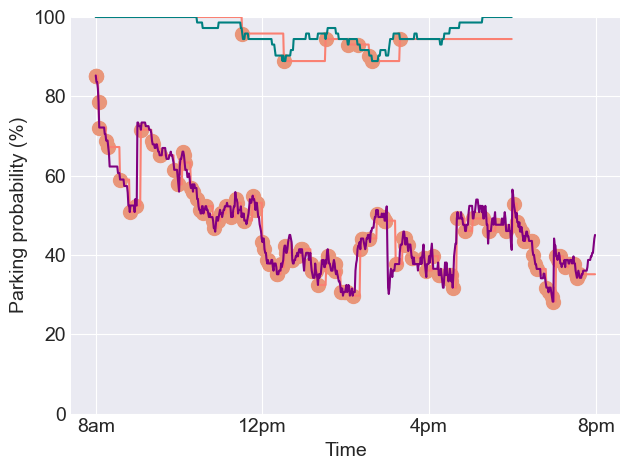

Saved to figs/seattle_occupancy_plot_adoption-30_seed-1.pdf


In [17]:
# Plot the observed probabilities against the true probabilities
plt.plot(observed_occupancy_df_pikeplace['OccupancyDateTime'], 100 - observed_occupancy_df_pikeplace['observed_occupancy_pct'], color='salmon')
plt.plot(observed_occupancy_df_pikeplace['OccupancyDateTime'], 100 - observed_occupancy_df_pikeplace['occupancy_pct'], label='Downtown Parking (Pike Place)', color='purple')
# Also plot when transactions occur as dots and put them at the height of the observed probability
plt.scatter(connected_user_transactions_df_pikeplace['Transaction DateTime'], 100 - connected_user_transactions_df_pikeplace['observed_occupancy_pct'], color='darksalmon', s=100)


# Plot the observed probabilities against the true probabilities
plt.plot(observed_occupancy_df_botanical['OccupancyDateTime'], 100 - observed_occupancy_df_botanical['observed_occupancy_pct'], color='salmon')
plt.plot(observed_occupancy_df_botanical['OccupancyDateTime'], 100 - observed_occupancy_df_botanical['occupancy_pct'], label='Outskirts Parking (Botanical Garden)', color='teal')
# Also plot when transactions occur as dots and put them at the height of the observed probability
plt.scatter(connected_user_transactions_df_botanical['Transaction DateTime'], 100 - connected_user_transactions_df_botanical['observed_occupancy_pct'], color='darksalmon', s=100)

# Format x-axis to show intuitive time
def format_time(x, pos=None):
    time_str = mdates.num2date(x).strftime('%I %p').lower()
    return time_str.lstrip('0').replace(" ", "")  # Remove leading zeros
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))

# Set to every-other tick
ticks = plt.gca().get_xticks()
plt.xticks(ticks[::2], fontsize=fontsize)

plt.ylim(0, 100)
plt.yticks(fontsize=fontsize)

plt.xlabel("Time", fontsize=fontsize)
plt.ylabel("Parking probability (%)", fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"{plots_dir_name}/seattle_occupancy_plot_adoption-{pct_connected_users}_seed-{random_seed}.pdf")

plt.show()

print(f"Saved to {plots_dir_name}/seattle_occupancy_plot_adoption-{pct_connected_users}_seed-{random_seed}.pdf")

In [18]:
# Compute the mean absolute error between the true and observed occupancy percentages
per_minute_errors = np.abs(observed_occupancy_df_pikeplace['occupancy_pct'] - observed_occupancy_df_pikeplace['observed_occupancy_pct'])
mean_abs_error = np.mean(per_minute_errors)
print(f"Mean absolute error: {mean_abs_error:.2f} percentage points")

# Plot the error distribution
if plot:
    plt.hist(per_minute_errors, bins=5, color='slateblue')
    plt.xlabel("Absolute errors (percentage points)")
    plt.ylabel("Frequency")
    plt.title(f"Absolute errors dist. (MAE of {mean_abs_error:.2f})\n{pct_connected_users}% connected user rate, {random_seed} seed")
    plt.show()

Mean absolute error: 2.03 percentage points


In [19]:
# Compute the mean absolute error between the true and observed occupancy percentages
per_minute_errors = np.abs(observed_occupancy_df_botanical['occupancy_pct'] - observed_occupancy_df_botanical['observed_occupancy_pct'])
mean_abs_error = np.mean(per_minute_errors)
print(f"Mean absolute error: {mean_abs_error:.2f} percentage points")

# Plot the error distribution
if plot:
    plt.hist(per_minute_errors, bins=5, color='slateblue')
    plt.xlabel("Absolute errors (percentage points)")
    plt.ylabel("Frequency")
    plt.title(f"Absolute errors dist. (MAE of {mean_abs_error:.2f})\n{pct_connected_users}% connected user rate, {random_seed} seed")
    plt.show()

Mean absolute error: 2.00 percentage points


### Compare error vs adoption rate with num_seeds simulations re-sampling which arrivals are from connected users 

In [20]:
# Define variables of interest
pct_connected_users_list = [5, 10, 20, 30, 40, 50, 60]
num_seeds = 100

In [21]:
plot=False

parking_key_list = [1017, 1018, 12869, 12874, 13301, 13302, 25705, 25706, 35909, 46250, 46254, 58629, 58629, 68914, 70741, 70746, 79354, 80198, 80878] # SDOT paid parking near Pike Place Market
local_occupancy_df_pikeplace = get_daily_occupancy_df(occupancy_df_path, target_date_str, parking_key_list, plot=plot)
local_transactions_df_pikeplace = get_daily_transactions_df(transactions_df_path, target_date_str, parking_key_list, plot=plot)

parking_key_list = [94731, 94732]   # SDOT paid parking near Carl S. English Jr. Botanical Garden
local_occupancy_df_botanical = get_daily_occupancy_df(occupancy_df_path, target_date_str, parking_key_list, plot=plot)
local_transactions_df_botanical = get_daily_transactions_df(transactions_df_path, target_date_str, parking_key_list, plot=plot)

Original size: 4.21 GB
Size when filtered to only 2025-01-30 date: 0.47 GB
Number of parking spaces in [1017, 1018, 12869, 12874, 13301, 13302, 25705, 25706, 35909, 46250, 46254, 58629, 58629, 68914, 70741, 70746, 79354, 80198, 80878] parking areas:
	61
Original size: 0.06 GB
Size when filtered to only 2025-01-30 date: 0.01 GB
Original size: 4.21 GB
Size when filtered to only 2025-01-30 date: 0.47 GB
Number of parking spaces in [94731, 94732] parking areas:
	72
Original size: 0.06 GB
Size when filtered to only 2025-01-30 date: 0.01 GB


In [22]:
# Store all daily average errors at each adoption rate
list_of_all_daily_maes_at_each_adoption_rate_pikeplace = []
list_of_all_daily_maes_at_each_adoption_rate_botanical = []

for pct_connected_users in pct_connected_users_list:

    # Store all daily average errors -- length of this list will be the number of seeds (num_seeds)
    daily_mean_abs_errors_pikeplace = []
    daily_mean_abs_errors_botanical = []

    for seed in range(random_seed, random_seed+num_seeds):

        observed_occupancy_df_pikeplace, _ = get_daily_connected_transactions_and_observed_occupancy(pct_connected_users, local_occupancy_df_pikeplace, local_transactions_df_pikeplace, seed, verbose=False)
        observed_occupancy_df_botanical, _ = get_daily_connected_transactions_and_observed_occupancy(pct_connected_users, local_occupancy_df_botanical, local_transactions_df_botanical, seed, verbose=False)

        # Compute the mean absolute error between the true and observed occupancy percentages
        per_minute_errors_pikeplace = np.abs(observed_occupancy_df_pikeplace['occupancy_pct'] - observed_occupancy_df_pikeplace['observed_occupancy_pct'])
        daily_mean_abs_error_pikeplace = np.mean(per_minute_errors_pikeplace)
        daily_mean_abs_errors_pikeplace.append(daily_mean_abs_error_pikeplace)

        per_minute_errors_botanical = np.abs(observed_occupancy_df_botanical['occupancy_pct'] - observed_occupancy_df_botanical['observed_occupancy_pct'])
        daily_mean_abs_error_botanical = np.mean(per_minute_errors_botanical)
        daily_mean_abs_errors_botanical.append(daily_mean_abs_error_botanical)

    list_of_all_daily_maes_at_each_adoption_rate_pikeplace.append(daily_mean_abs_errors_pikeplace)
    list_of_all_daily_maes_at_each_adoption_rate_botanical.append(daily_mean_abs_errors_botanical)


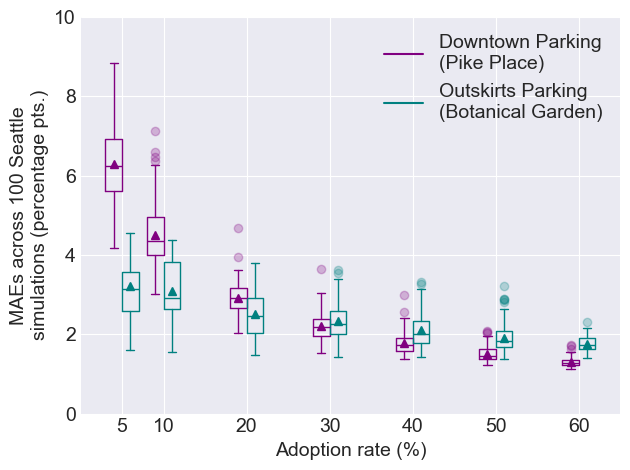

In [23]:
# Width of each box (adjust as needed)
box_width = 2

# Offset for the second set of boxplots
offset = box_width 

# Create the first box-and-whisker plot (Pike Place)
box_and_whisker_color_pikeplace = 'purple'
mean_median_color_pikeplace = 'purple'

plt.boxplot(list_of_all_daily_maes_at_each_adoption_rate_pikeplace,
            positions=np.array(pct_connected_users_list),  # Use numpy array for offset
            widths=box_width,
            showfliers=True,
            showmeans=True,
            boxprops={'color': box_and_whisker_color_pikeplace},
            whiskerprops={'color': box_and_whisker_color_pikeplace},
            capprops={'color': box_and_whisker_color_pikeplace},
            flierprops={'markerfacecolor': box_and_whisker_color_pikeplace, 'markeredgecolor': box_and_whisker_color_pikeplace, 'alpha': 0.25},
            medianprops={'color': mean_median_color_pikeplace},
            meanprops={'markerfacecolor': mean_median_color_pikeplace, 'markeredgecolor': mean_median_color_pikeplace}
            )

# Create the second box-and-whisker plot (Botanical Garden)
box_and_whisker_color_botanical = 'teal'
mean_median_color_botanical = 'teal'

plt.boxplot(list_of_all_daily_maes_at_each_adoption_rate_botanical,
            positions=np.array(pct_connected_users_list) + offset,  # Offset the positions
            widths=box_width,
            showfliers=True,
            showmeans=True,
            boxprops={'color': box_and_whisker_color_botanical},
            whiskerprops={'color': box_and_whisker_color_botanical},
            capprops={'color': box_and_whisker_color_botanical},
            flierprops={'markerfacecolor': box_and_whisker_color_botanical, 'markeredgecolor': box_and_whisker_color_botanical, 'alpha': 0.25},
            medianprops={'color': mean_median_color_botanical},
            meanprops={'markerfacecolor': mean_median_color_botanical, 'markeredgecolor': mean_median_color_botanical}
            )

# Add labels
plt.plot([], [], color=box_and_whisker_color_pikeplace, label='Downtown Parking\n(Pike Place)')
plt.plot([], [], color=box_and_whisker_color_botanical, label='Outskirts Parking\n(Botanical Garden)')

plt.xlabel("Adoption rate (%)", fontsize=fontsize)
plt.ylabel(f"MAEs across {num_seeds} Seattle\nsimulations (percentage pts.)", fontsize=fontsize)
plt.xticks(np.array(pct_connected_users_list) + offset/2, [int(x) for x in pct_connected_users_list], fontsize=fontsize) # Centered ticks
plt.yticks(fontsize=fontsize)

plt.legend(fontsize=fontsize)

plt.ylim(0, 10.0)  
plt.tight_layout()
plt.savefig(f"{plots_dir_name}/error_boxplot_seattle.pdf")
plt.show()